# 🚀 Quick Start

## Overview

This notebook presents a minimal working example showing how to run a cable layout optimization using *OptiWindNet* by just a few lines of code with the **Network/Router high-level API**.
It is ideal for **first-time users** looking for **immediate results** with **minimal setup**.

A network optimization needs two components: a `WindFarmNetwork` instance containing information about the problem and a `Router` instance containing information about the method to solve the problem.

## Steps

1. **Create a** `WindFarmNetwork` **instance**
   
   To initialize the network object, the following data is required:

   * **Required:**

     * Turbine and substation coordinates
       *(See [Data Input](a01_data_input.ipynb) for various input formats.)*
     * Cable data (e.g., capacities and costs or, at least, maximum cable capacity as single number)

   * **Optional:**

     * **Borders and obstacles**: if not provided, the optimization runs without spatial constraints.
     * **Router**: the optimization solver to be used.
       If not specified, `EWRouter` is used as default.
       You can also set or override the router at the time of optimization via `WindFarmNetwork_instance.optimize(router=...)`.
     * **`buff_dist`**: a buffer distance applied to borders and obstacles to slightly expand or shrink them.
       This helps when turbines are close to the edge or when integrating with external tools like **TopFarm**.

2. **Define a router**
   
   You can either provide the router when initializing the `WindFarmNetwork` or directly when calling `.optimize()`.

3. **Run the optimization**
  
   Call:

   ```python
   WindFarmNetwork_instance.optimize(router=desired_router)
   ```

4. **Access results**
   Use `WindFarmNetwork` methods to retrieve outputs such as:

   * Total network **length** and **cost**
   * **Plots** of the network, links, and routes
   * Detailed edge and cable information

## Define the problem with `WindFarmNetwork`

In [23]:
from optiwindnet.api import WindFarmNetwork

In [24]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

Load location data

> Note: *OptiWindNet*'s `load_repository()` reads locations from a folder containing several *.yaml* or *.osm.pbf* files. It returns a named tuple with *NetworkX.Graph* instances as members (one for each file). For more details, check [Load repositories containing location data](a03_load_repositories.ipynb).

In [25]:
from optiwindnet.api import load_repository
locations = load_repository()
L = locations.doggerA

Initialize a `WindFarmNetwork` instance with a prebuilt `L` and maximum cable capacity *(See [Data Input](a01_data_input.ipynb) for various input formats.)*

In [26]:
wfn = WindFarmNetwork(L=L, cables=8)

We can plot the location to make sure `wfn` is created with the correct data.

<Axes: >

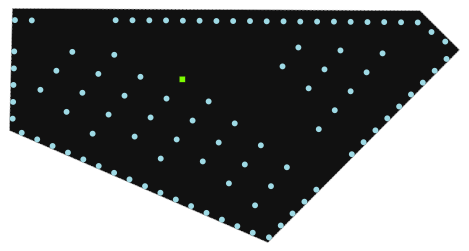

In [27]:
wfn.plot_location()

## Define the method with a `Router`

The routers currently included in the `optiwindnet.api` module are:

* **EWRouter**

  * *Fastest option* — completes in a fraction of a second
  * Great for quick layout generation
  * Produces only **branched-topology** solutions
  * Heuristic method (EW = Esau-Williams) -- solutions may be far from the optimum

* **HGSRouter**

  * *Still fast* — can provide high-quality solutions in **0.5–2 seconds**
  * Produces only **radial-topology** solutions (no branching)
  * A maximum number of feeders can be enforced
  * Meta-heuristic method (HGS = Hybrid Genetic Search)

* **MILPRouter**

  * Delivers solutions with **quality guarantees** (a bound on the distance from the optimum)
  * May take a **few to several minutes** depending on the problem size and quality required
  * Full set of model options to choose from
  * Should be used when optimality is more important than speed
  * MILP = Mixed Integer Linear Programming



### EWRouter

To use this router, simply create an instance of the `EWRouter` class.

All arguments are **optional**, making it quick and easy to get started with minimal configuration.

In [28]:
from optiwindnet.api import EWRouter

In [29]:
ew_router = EWRouter()

In [30]:
%%timeit
res_ew = wfn.optimize(router=ew_router)

62.8 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
wfn.length()

264936.30102115136

<Axes: >

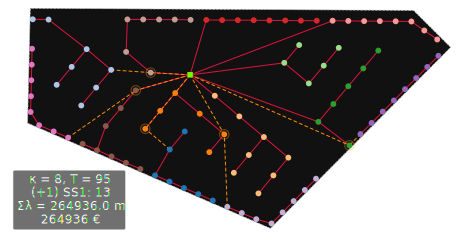

In [32]:
wfn.plot()

### HGSRouter 
(fast - radial only solutions)

To use this router, create an instance of the `HGSRouter` class.

The **only required argument** is `time_limit`, which defines how long the optimization is allowed to run (in seconds).

This approach produces **radial-topology** networks.

In [33]:
from optiwindnet.api import HGSRouter

In [34]:
hgs_router = HGSRouter(time_limit=1)

> **Note:** When calling `.optimize()` multiple times on the **same** `WindFarmNetwork` instance, the previously stored solution and related information (e.g., network graph, cost, length) will be **overwritten**.
> You can verify this by checking the updated total length or by re-plotting the optimized network and comparing it to the earlier result.

In [35]:
res_hgs = wfn.optimize(router=hgs_router)

In [36]:
wfn.router

In [37]:
wfn.length()

243732.29475632898

#### Plot the optimized network

>**Note:** the optimized network has a **radial layout**, forming a single connected tree without any subtree.

<Axes: >

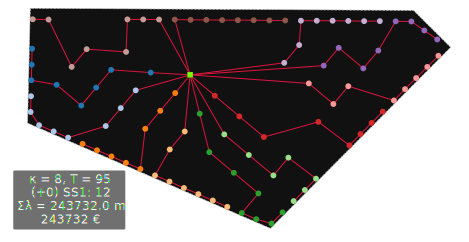

In [38]:
wfn.plot()

### MILPRouter
(high-quality solutions with guarantees – may take several minutes)

To use this router, create an instance of the `MILP` class.
You must provide:

* `solver_name`: the MILP solver to use (e.g., `'ortools'`, `'gurobi'`, `'cbc'`)
* `time_limit`: maximum time allowed for solving (in seconds)
* `mip_gap`: acceptable optimality gap (e.g., `0.005` = 0.5%)

Optional arguments:

* `verbose` *(default: False)*: set to `True` to display solver progress and detailed logs
* `solver_options`: dictionary of solver-specific parameters
* `model_options`: advanced model settings (e.g., topology, feeder configuration)

In [39]:
from optiwindnet.api import MILPRouter

In [40]:
milp_router = MILPRouter(solver_name='ortools', time_limit=20, mip_gap=0.005, verbose=True)

If you run the optimization using *MILPRouter* on a **`WindFarmNetwork` instance** that already contains a aolution, it will automatically use the **previous solution as a warm start**.
To run MILP **without warm-starting**, create a **new instance** of the `WindFarmNetwork` object and run the MILP optimization directly—**without any prior runs using other solvers**.

> An informative message will be printed about warmstating if `verbose=True`. You can also observe this in the log messages of the MILP router,  where the MILP solver starts with an **initial incumbent solution**.


In [41]:
res_milp = wfn.optimize(router=milp_router)

✅ Using warm start: the model is initialized with the provided solution S.


Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 20 log_search_progress: true relative_gap_limit: 0.005
Setting number of workers to 8

Initial optimization model '': (model_fingerprint: 0xb9c432506ee1c1f3)
#Variables: 1'690 (#bools: 845 in floating point objective) (1'500 primary variables)
  - 845 Booleans in [0,1]
  - 750 in [0,7]
  - 95 in [0,8]
#kAtMostOne: 635 (#literals: 1'926)
#kLinear1: 1'690 (#enforced: 1'690)
#kLinear3: 4
#kLinearN: 284 (#terms: 4'213)

Starting presolve at 0.01s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 845 terms with magnitude in [1409.66, 22631.9] average = 4594.28
[Scaling] Objective coefficient relative error: 1.60816e-10
[Scaling] Objective worst-case absolute error: 5.3597e-05
[Scaling] Objective scaling factor: 2.09715e+06
  1.74e-03s  0.00e+00d  [DetectDominanceRelations] 
  3.10e-02s  0.00e+00d  [operations_rese

In [42]:
wfn.router

In [43]:
wfn.length()

243331.73581275754

<Axes: >

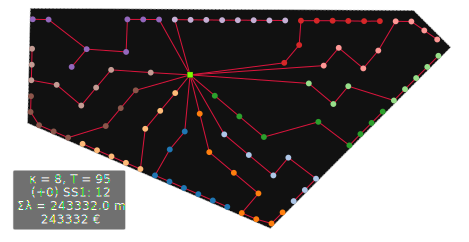

In [44]:
wfn.plot()